In [1]:
import pandas as pd
from Bio import SeqIO
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import MultiLabelBinarizer

from pymmseqs.commands import easy_cluster
import os
import re

# Toxins
(taxonomy_id:33208) AND (cc_tissue_specificity:venom) AND (reviewed:true) AND (keyword:KW-0800) AND (fragment:false)

In [2]:
tox = pd.read_csv('../data/raw/tox.tsv', sep='\t')
tox = tox.dropna(subset=["Protein families"])

tox

,Entry,Sequence,Protein families
0,A0A0B4U9L8,MLQVLLVTICLAVFPYQGSSIILESGNVNDYEVVYPQKLTALLKGA...,"Venom metalloproteinase (M12B) family, P-III s..."
1,A0A0B5A8P4,MTTSFYFLLVALGLLLYVCQSSFGNQHTRNSDTPKHRCGSELADQY...,Insulin family
2,A0A0B5AC95,MTTSSYFLLMALGLLLYVCQSSFGNQHTRTFDTPKHRCGSEITNSY...,Insulin family
3,A0A0D4WV12,GDSRRPIWNIAHMVNDLDLVDEYLDDGANSLELDVEFSKSGTALRT...,"Arthropod phospholipase D family, Class II sub..."
4,A0A0N7CSQ4,MLKSFCILSVFMVLFLAKFPDLCSGEEISPLKIVVRNSEYLNNPCN...,Scoloptoxin-04 family
...,...,...,...
5308,W4VSI7,MKPTISILIFFALAVAIMGHRLNSGYGIPHIVEKLPNGQWCRTPGD...,Neurotoxin 21 family
5309,W4VSI8,MMKLYSLVIIATLAAAAFAATSEEISAAVSEIISQHQEDLERYAKI...,"Neurotoxin 25 family, ICK-8 subfamily"
5310,W4VSI9,MKTLVLVAVLGVASLYLLSSASEVQQLSPAEEEFRAFVSTFGGLFE...,"Neurotoxin 10 (Hwtx-1) family, 27 (ICK-3) subf..."
5311,X5IFY8,MGKLTILVLVAAVLLSTQAMVQGDGDQPAARNAVPRDDNPDGPSAK...,"O2 superfamily, Contryphan family"


In [3]:
tox['Protein families'] = tox['Protein families'].str.split(',').str[0]
tox['Protein families'] = tox['Protein families'].str.split(';').str[0]

In [4]:
tox['Protein families'] = tox['Protein families'].replace('I1 superfamily', 'Conotoxin I1 superfamily')
tox['Protein families'] = tox['Protein families'].replace('O1 superfamily', 'Conotoxin O1 superfamily')
tox['Protein families'] = tox['Protein families'].replace('O2 superfamily', 'Conotoxin O2 superfamily')
tox['Protein families'] = tox['Protein families'].replace('E superfamily', 'Conotoxin E superfamily')
tox['Protein families'] = tox['Protein families'].replace('F superfamily', 'Conotoxin F superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin M family', 'Conotoxin M superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin B2 family', 'Conotoxin B2 superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin O1 family', 'Conotoxin O1 superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin O2 family', 'Conotoxin O2 superfamily')

In [5]:
mapping = {
    r'Conotoxin.*': 'Conotoxin family',
    r'Neurotoxin.*': 'Neurotoxin family',
    r'Scoloptoxin.*|Scolopendra.*': 'Scoloptoxin family',
    r'Caterpillar.*': 'Caterpillar family',
    r'Teretoxin.*': 'Teretoxin family',
    r'Limacoditoxin.*': 'Limacoditoxin family',
    r'Scutigerotoxin.*': 'Scutigerotoxin family',
    r'Cationic peptide.*': 'Cationic peptide family',
    r'Formicidae venom.*': 'Formicidae venom family',
    r'Bradykinin-potentiating peptide family|Natriuretic peptide family': 'Natriuretic, Bradykinin potentiating peptide family',
    r'.*phospholipase.*|.*Phospholipase.*': 'Phospholipase family'
}

# Apply mapping
for pattern, replacement in mapping.items():
    tox['Protein families'] = tox['Protein families'].str.replace(pattern, replacement, regex=True)

# everything with less than 3 samples is "other"
tox["Protein families"] = tox["Protein families"].where(tox["Protein families"].map(tox["Protein families"].value_counts()) >= 3, "other")

tox['Protein families'].value_counts()

Protein families
Conotoxin family                                        990
Neurotoxin family                                       959
Three-finger toxin family                               485
Long (4 C-C) scorpion toxin superfamily                 339
Phospholipase family                                    320
                                                       ... 
Redulysin-like family                                     3
Elevenin family                                           3
Beta-defensin family                                      3
Helical arthropod-neuropeptide-derived (HAND) family      3
Multicopper oxidase family                                3
Name: count, Length: 69, dtype: int64

# Non-Toxins
(taxonomy_id:33208) AND (reviewed:true) AND (fragment:false) NOT (keyword:KW-0800) AND ((existence:1) OR (existence:2))

In [42]:
nontox = pd.read_csv('../data/raw/nontox.tsv', sep='\t')

mask = nontox["Sequence"].str.len() <= 2000
removed = (~mask).sum()

nontox = nontox[mask].reset_index(drop=True)

nontox

,Entry,Sequence,Protein families
0,A0A026W182,MMKMKQQGLVADLLPNIRVMKTFGHFVFNYYNDNSSKYLHKVYCCV...,"Insect chemoreceptor superfamily, Heteromeric ..."
1,A0A044RE18,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,"Peptidase S8 family, Furin subfamily"
2,A0A061I403,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,Fic family
3,A0A075F932,MVSESHHEALAAPPATTVAAAPPSNVTEPASPGGGGGKEDAFSKLK...,Synaptotagmin family
4,A0A087WPF7,MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...,AUTS2 family
...,...,...,...
82648,Q9W3M2,MAKRGKKGGIPRAEMVQVASANRDENQVTELKKADYLPYLFNLVMP...,DM7 family
82649,Q9WVB7,MKPPMQPLTQALPFSLRDALQGTGLRVPVIKMGTGWEGMYRTLKEV...,NaN
82650,Q9XVA4,MPDNHKDPPDFNNLEMKLEERIELSREDQDIQSTSSSYPHCEALDH...,NaN
82651,Q9Y0Y7,MERRYLKNPFPDFAGGENTPFASDEEHIKNLICTYVDAILEHCHPN...,LanC-like protein family


### Fasta Generation

In [43]:
def write_fasta(df, filename):
    """Writes a DataFrame to a FASTA file."""
    with open(filename, "w") as f:
        for _, row in df.iterrows():
            f.write(f">{row['Entry']}\n{row['Sequence']}\n")

write_fasta(tox, "../data/raw/tox.fasta")
write_fasta(nontox, "../data/raw/nontox.fasta")

## Remove SPs

In [ ]:
!signalp6 --fastafile ../data/raw/tox.fasta --output_dir ../data/sp6/tox/ --organism eukarya --mode fast --model_dir /Users/selin/Desktop/Uni/signalp6/signalp-6-package/models/

In [ ]:
!signalp6 --fastafile ../data/nontox.fasta --output_dir ../data/sp6/nontox/ --organism eukarya --mode fast --model_dir /Users/selin/Desktop/Uni/signalp6/signalp-6-package/models/

In [8]:
def fasta_to_dataframe(fasta_file):
    records = SeqIO.parse(fasta_file, "fasta")
    data = []

    for record in records:
        id_part = record.id.split('|')[-1]
        data.append({"identifier": id_part, "Sequence": str(record.seq)})

    df = pd.DataFrame(data)
    return df

# SignalP6 all (processed) sequences
proc_tox = fasta_to_dataframe("../data/sp6/tox/processed_entries.fasta")
proc_nontox = fasta_to_dataframe("../data/sp6/nontox/processed_entries.fasta")
#proc_tox = proc_tox.rename(columns={'Sequence': 'Sequence'})
#proc

In [9]:
proc_tox

,identifier,Sequence
0,A0A0B4U9L8,IILESGNVNDYEVVYPQKLTALLKGAIQQPEQKYEDAMQYEFKVNG...
1,A0A0B5A8P4,NQHTRNSDTPKHRCGSELADQYVQLCHGKRNDAGKKRGRASPLWQR...
2,A0A0B5AC95,NQHTRTFDTPKHRCGSEITNSYMDLCYRKRNDAGEKRGRASPLWQR...
3,A0A0N7CSQ4,EEISPLKIVVRNSEYLNNPCNGVTCPSGYRCSIVDKQCIKKEK
4,A0A193CHJ5,HLLQFNKMIKFETRKNAIPFYAFYGCYCGWGGRGRPKDATDRCCFV...
...,...,...
3455,W4VSI7,HRLNSGYGIPHIVEKLPNGQWCRTPGDDCSESKQCCKPEDTATYAH...
3456,W4VSI8,ATSEEISAAVSEIISQHQEDLERYAKIVERGEEPKKYIRCSKQLGQ...
3457,W4VSI9,SEVQQLSPAEEEFRAFVSTFGGLFETEERGVDSEDCRAMFGGCGED...
3458,X5IFY8,DGDQPAARNAVPRDDNPDGPSAKFMNVQRRSGCPWEPWCG


In [10]:
gff3_tox = pd.read_csv('../data/sp6/tox/output.gff3', sep='\t', comment='#', header=None)
gff3_nontox = pd.read_csv('../data/sp6/nontox/output.gff3', sep='\t', comment='#', header=None)

cols = [
    'identifier', 'source', 'feature_type', 'start', 'end',
    'score', 'strand', 'phase', 'attributes'
]
gff3_tox.columns = cols
gff3_nontox.columns = cols

def extract_seqid(full_seqid):
    return full_seqid.split('|')[-1].split(' ')[0]

gff3_tox['identifier'] = gff3_tox['identifier'].apply(extract_seqid)
gff3_nontox['identifier'] = gff3_nontox['identifier'].apply(extract_seqid)

gff3_tox = pd.merge(gff3_tox, proc_tox, on='identifier')
gff3_nontox = pd.merge(gff3_nontox, proc_nontox, on='identifier')

In [11]:
gff3_tox[gff3_tox['score'] < 0.8]

,identifier,source,feature_type,start,end,score,strand,phase,attributes,Sequence
7,A0A2U8QPE6,SignalP-6.0,signal_peptide,1,19,0.582636,.,.,.,DDTRPLGECFREADYEEFLEIARNGLKKTSNPKHVVVVGAGMSGLS...
22,A8QL52,SignalP-6.0,signal_peptide,1,18,0.655870,.,.,.,ADDRRSALEECFREADYEEFLEIARNGLKKTSNPKHVVVVGAGMAG...
40,C0HJE7,SignalP-6.0,signal_peptide,1,19,0.622422,.,.,.,HDRNPLEECFRETDYEEFLEIARNGLTVTSNPKHVVIVGAGMAGLS...
79,G8XQX1,SignalP-6.0,signal_peptide,1,18,0.618284,.,.,.,ADDKNPLEECFREDDYEEFLEIAKNGLKKTSNPKHIVIVGAGMSGL...
82,J7H670,SignalP-6.0,signal_peptide,1,19,0.590507,.,.,.,DDRNPLGECFRETDYEEFLEIAKNGLRATSNPKHVVIVGAGMSGLS...
89,O93364,SignalP-6.0,signal_peptide,1,19,0.633526,.,.,.,HDRNPLEECFRETDYEEFLEIAKNGLTATSNPKRVVIVGAGMAGLS...
113,P07231,SignalP-6.0,signal_peptide,1,21,0.735614,.,.,.,TGTLDDGGALTERRSADATALKAEPVLLQKSAARSTDDNGKDRLTQ...
179,P56742,SignalP-6.0,signal_peptide,1,19,0.633526,.,.,.,HDRNPLEECFRETDYEEFLEIAKNGLTATSNPKRVVIVGAGMAGLS...
182,P58806,SignalP-6.0,signal_peptide,1,26,0.500608,.,.,.,HGGALTERRSTDATALKPEPVLLQKSSARSTDDNGNDRLTQMKRIL...
210,P81382,SignalP-6.0,signal_peptide,1,19,0.624410,.,.,.,DDRNPLAECFQENDYEEFLEIARNGLKATSNPKHVVIVGAGMAGLS...


### merge with SP6 predictions

In [12]:
# Merge with tox, replacing 'Sequence' where Entry matches

filtered = gff3_tox[gff3_tox['score'] > 0.8][['identifier', 'Sequence']]
filtered = filtered.rename(columns={'identifier': 'Entry'})
tox.update(filtered.set_index('Entry'))

filtered = gff3_nontox[gff3_nontox['score'] > 0.8][['identifier', 'Sequence']]
filtered = filtered.rename(columns={'identifier': 'Entry'})
nontox.update(filtered.set_index('Entry'))

In [13]:
write_fasta(tox, "../data/interm/tox_noSP.fasta")
write_fasta(nontox, "../data/interm/nontox_noSP.fasta")

## Clustering
### run mmseqs2 90% sequence similarity clustering per protein family

In [14]:
out_dir = "../data/families/"
os.makedirs(out_dir, exist_ok=True)

def sanitize_filename(name):
    return re.sub(r"[^a-zA-Z0-9_-]", "_", name)

failed = []

for family, group in tox.groupby("Protein families"):
    safe_family = sanitize_filename(family)

    fasta_path = os.path.join(out_dir, f"{safe_family}.fasta")
    write_fasta(group, fasta_path)

    # Create family-specific mmseqs directory
    family_mmseqs_dir = os.path.join("/Users/selin/PycharmProjects/ToxFam/data/mmseqs", safe_family)
    os.makedirs(family_mmseqs_dir, exist_ok=True)

    cluster_prefix = os.path.join(family_mmseqs_dir, "cluster")
    tmp_dir = os.path.join(family_mmseqs_dir, "tmp")
    os.makedirs(tmp_dir, exist_ok=True)

    try:
        easy_cluster(
            fasta_files=fasta_path,
            cluster_prefix=cluster_prefix,
            tmp_dir=tmp_dir,
            min_seq_id=0.9
        )
    except Exception as e:
        print(f"⚠️ Skipping {safe_family} due to error: {e}")
        failed.append((fasta_path, cluster_prefix, tmp_dir))

# Print mmseqs commands for failures
if failed:
    print("\n🔁 Manual mmseqs2 commands for failed entries:\n")
    for fasta, out, tmp in failed:
        print(f"mmseqs easy-cluster {fasta} {out} {tmp} --min-seq-id 0.9")


-------------------- Running a mmseqs2 command --------------------
✓ Detailed execution log has been saved
✓ Easy Cluster completed successfully
  Results saved to: /Users/selin/PycharmProjects/ToxFam/data/mmseqs/AVIT__prokineticin__family/cluster

-------------------- Running a mmseqs2 command --------------------
✓ Detailed execution log has been saved
✓ Easy Cluster completed successfully
  Results saved to: /Users/selin/PycharmProjects/ToxFam/data/mmseqs/Asilidin-1_family/cluster

-------------------- Running a mmseqs2 command --------------------
✓ Detailed execution log has been saved
✓ Easy Cluster completed successfully
  Results saved to: /Users/selin/PycharmProjects/ToxFam/data/mmseqs/Beta-defensin_family/cluster

-------------------- Running a mmseqs2 command --------------------
✓ Detailed execution log has been saved
✓ Easy Cluster completed successfully
  Results saved to: /Users/selin/PycharmProjects/ToxFam/data/mmseqs/Bradykinin_inhibitor_peptide_family/cluster

-----

In [15]:
mmseqs_base_dir = "/Users/selin/PycharmProjects/ToxFam/data/mmseqs"
rep_seqs = []

# Go through each family subdirectory (excluding "nontox")
for family_dir in os.listdir(mmseqs_base_dir):
    if family_dir == "nontox":
        continue

    full_path = os.path.join(mmseqs_base_dir, family_dir)
    if not os.path.isdir(full_path):
        continue

    rep_fasta = os.path.join(full_path, "cluster_rep_seq.fasta")
    if not os.path.exists(rep_fasta):
        continue

    # Parse FASTA and collect entries
    for record in SeqIO.parse(rep_fasta, "fasta"):
        rep_seqs.append({
            "Entry": record.id,
            "Sequence": str(record.seq),
        })

# Create DataFrame
rep_df = pd.DataFrame(rep_seqs).merge(tox[["Entry", "Protein families"]], on="Entry", how="left")
rep_df

,Entry,Sequence,Protein families
0,I2C090,MEGMALYLVAALLIGFPGSSHGALYTLITPGVLRTDTEEQILVEAH...,Venom complement C3 homolog family
1,Q91132,MERMALYLVAALLIGFPGSSHGALYTLITPAVLRTDTEEQILVEAH...,Venom complement C3 homolog family
2,A0RZC6,MEGMALYLVAALLIGFPGSSHGALYTLITPGVLRTDTEEQILVEAH...,Venom complement C3 homolog family
3,J3S836,MEGMALYLVAALLIGFPASSFGALYTFITPGVLRTDTEEKILVEAH...,Venom complement C3 homolog family
4,C6EVG1,MKIILWLCVFGLFLATLFPISWQMPVESGLSSEDSASSESFASKIK...,Glucagon family
...,...,...,...
3074,Q9BLM2,MNYLVMISFALLLVIGVESVRDGYFVEPDNCVIYCMPSSEVCDRGC...,Long (3 C-C) scorpion toxin superfamily
3075,Q66S03,MASVPHFTVFLFLACALGIGANVTRRATSSCPKGWTHHGSRCFTFH...,True venom lectin family
3076,A7X3W6,MGQFTVVSLGLLAMFLSLSGAKGDNCPASWISRNGVCNKLFPDRKT...,True venom lectin family
3077,A7X3X0,MGQFTVVSLGLLAMFLSLSGAKGDNCPASWISRNGVCNKLFPDRKT...,True venom lectin family


In [16]:
rep_df["Protein families"] = rep_df["Protein families"].where(rep_df["Protein families"].map(rep_df["Protein families"].value_counts()) >= 3, "other")
rep_df["Protein families"].value_counts()

Protein families
Conotoxin family                                       728
Neurotoxin family                                      393
Three-finger toxin family                              258
Long (4 C-C) scorpion toxin superfamily                221
Short scorpion toxin superfamily                       183
Phospholipase family                                   170
Venom metalloproteinase (M12B) family                  122
Scoloptoxin family                                     119
Snaclec family                                          93
Peptidase S1 family                                     87
Natriuretic, Bradykinin potentiating peptide family     69
MCD family                                              59
other                                                   53
Cationic peptide family                                 51
Venom Kunitz-type family                                48
Formicidae venom family                                 34
Long (3 C-C) scorpion toxin superfamily

### Train-Val-Test sets with 70:15:15 split

In [17]:
# Ensure 'Protein families' is split only if not already a list
rep_df['Protein families'] = rep_df['Protein families'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

# Create binary indicator matrix
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(rep_df['Protein families'])

# Save label classes (optional)
label_classes = mlb.classes_

# Train+val vs test split (test=15%)
msss1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
idx_train_val, idx_test = next(msss1.split(rep_df, y))

rep_df_train_val = rep_df.iloc[idx_train_val].copy()  # add .copy() here
y_train_val = y[idx_train_val]

# Train vs val split (val = 15% / (1-0.15) ~0.176 of train_val)
val_size = 0.15 / (1 - 0.15)
msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
idx_train, idx_val = next(msss2.split(rep_df_train_val, y_train_val))

train_df = rep_df_train_val.iloc[idx_train].copy()  # add .copy() here
val_df = rep_df_train_val.iloc[idx_val].copy()      # add .copy() here
test_df = rep_df.iloc[idx_test].copy()              # add .copy() here

# Join lists back to strings with .loc
train_df.loc[:, 'Protein families'] = train_df['Protein families'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)
val_df.loc[:, 'Protein families'] = val_df['Protein families'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)
test_df.loc[:, 'Protein families'] = test_df['Protein families'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

In [18]:
def print_split_sizes(train_df, val_df, test_df, total_df):
    print(f"Train size: {len(train_df)} ({len(train_df)/len(total_df)*100:.2f}%)")
    print(f"Validation size: {len(val_df)} ({len(val_df)/len(total_df)*100:.2f}%)")
    print(f"Test size: {len(test_df)} ({len(test_df)/len(total_df)*100:.2f}%)")
print_split_sizes(train_df, val_df, test_df, rep_df)

Train size: 2143 (69.60%)
Validation size: 469 (15.23%)
Test size: 467 (15.17%)


/var/folders/6k/gr_1_h_97154rq71pm_q3jn40000gn/T/ipykernel_26070/2101714188.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', num_colors)


<Figure size 3000x2100 with 0 Axes>

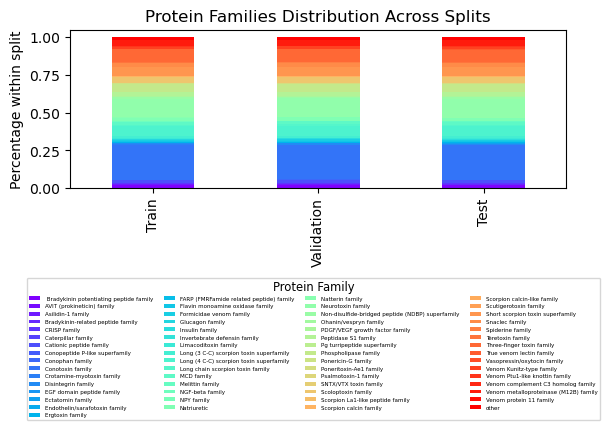

In [19]:
def plot_protein_family_distribution(train_df, val_df, test_df):
    def get_family_percentages(df):
        return df['Protein families'].str.split(',').explode().value_counts(normalize=True).sort_index()

    train_pct = get_family_percentages(train_df)
    val_pct = get_family_percentages(val_df)
    test_pct = get_family_percentages(test_df)

    all_families = sorted(set(train_pct.index) | set(val_pct.index) | set(test_pct.index))

    train_pct = train_pct.reindex(all_families, fill_value=0)
    val_pct = val_pct.reindex(all_families, fill_value=0)
    test_pct = test_pct.reindex(all_families, fill_value=0)

    df_pct = pd.DataFrame({
        'Train': train_pct,
        'Validation': val_pct,
        'Test': test_pct
    }).T

    # Generate rainbow colormap with number of families colors
    num_colors = len(all_families)
    cmap = cm.get_cmap('rainbow', num_colors)
    colors = [cmap(i) for i in range(num_colors)]

    plt.figure(figsize=(10,7), dpi=300)
    ax = df_pct.plot(kind='bar', stacked=True, color=colors)

    plt.ylabel('Percentage within split')
    plt.title('Protein Families Distribution Across Splits')

    plt.legend(title='Protein Family', loc='upper center',
           bbox_to_anchor=(0.49, -0.55),  # below plot
           fontsize=4, title_fontsize='small', ncol=4)
    plt.subplots_adjust(bottom=0.55)  # add space below plot for legend

    plt.savefig('../data/train_distribution.png', dpi=300)
    plt.show()

# Usage
plot_protein_family_distribution(train_df, val_df, test_df)

In [20]:
train_df

,Entry,Sequence,Protein families
0,I2C090,MEGMALYLVAALLIGFPGSSHGALYTLITPGVLRTDTEEQILVEAH...,Venom complement C3 homolog family
3,J3S836,MEGMALYLVAALLIGFPASSFGALYTFITPGVLRTDTEEKILVEAH...,Venom complement C3 homolog family
4,C6EVG1,MKIILWLCVFGLFLATLFPISWQMPVESGLSSEDSASSESFASKIK...,Glucagon family
6,C6EVG2,MKSILWLCVFGLLIATLFPVSWQMAIKSRLSSEDSETDQRLFESKR...,Glucagon family
7,P01501,MKFLVNVALVFMVVYISYIYAAPEPEPAPEPEAEADAEADPEAGIG...,Melittin family
...,...,...,...
3072,Q4LCT3,MMKLVLFSVIVILFSLIGSIHGADVPGNYPLRPFRYRYGCAVPGDS...,Long (3 C-C) scorpion toxin superfamily
3073,Q9BLM1,MNYLVMISFALLLVIGVESVRDGYFVEPDNCLVYCMPSPEICDRGC...,Long (3 C-C) scorpion toxin superfamily
3074,Q9BLM2,MNYLVMISFALLLVIGVESVRDGYFVEPDNCVIYCMPSSEVCDRGC...,Long (3 C-C) scorpion toxin superfamily
3077,A7X3X0,MGQFTVVSLGLLAMFLSLSGAKGDNCPASWISRNGVCNKLFPDRKT...,True venom lectin family


## redundancy reduction nontox

In [44]:
!mmseqs easy-cluster ../data/raw/nontox.fasta ../data/mmseqs/nontox/cluster ../data/mmseqs/nontox/tmp --min-seq-id 0.9

easy-cluster ../data/raw/nontox.fasta ../data/mmseqs/nontox/cluster ../data/mmseqs/nontox/tmp --min-seq-id 0.9 

MMseqs Version:                     	17.b804f
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues          

In [45]:
rep_seqs = []

nontox_dir = os.path.join(mmseqs_base_dir, "nontox")
if os.path.isdir(nontox_dir):
    rep_fasta = os.path.join(nontox_dir, "cluster_rep_seq.fasta")
    if os.path.exists(rep_fasta):
        for record in SeqIO.parse(rep_fasta, "fasta"):
            rep_seqs.append({
                "Entry": record.id,
                "Sequence": str(record.seq),
            })

# Create DataFrame
rep_df = pd.DataFrame(rep_seqs)
rep_df

,Entry,Sequence
0,A0A026W182,MMKMKQQGLVADLLPNIRVMKTFGHFVFNYYNDNSSKYLHKVYCCV...
1,A0A044RE18,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...
2,A0A061I403,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...
3,A0A075F932,MVSESHHEALAAPPATTVAAAPPSNVTEPASPGGGGGKEDAFSKLK...
4,A0A096MK47,MTSCVLAGSIETTPKVSPGDSEAKPLIFTFVPTLRRLPTHIQLADT...
...,...,...
53719,Q9GKR7,MEEDSQEDSNLPPKVWHSEMTVSVTGKPPSTVEEDGLPKETDVETI...
53720,Q9GKU1,MALTVDVAGPAPWGFRITGGRDFHTPIMVTKVAERGKAKDADLRPG...
53721,Q9GL01,MAPPGSRTVLLLALTIIARTQALKPTHYLTKHDVERLKASLDRPFT...
53722,Q9GL25,MNPWSSYLLGWTTFLLYFYETSGKIPNLSSLGKHEFTKPWISIKED...


In [46]:
# Split into 70% train and 30% temp
nontox_train_df, nontox_temp_df = train_test_split(rep_df, test_size=0.30, shuffle=True, random_state=42)

# Split temp into 15% val and 15% test
nontox_val_df, nontox_test_df = train_test_split(nontox_temp_df, test_size=0.50, shuffle=True, random_state=42)
print_split_sizes(nontox_train_df,nontox_val_df,nontox_test_df,rep_df)

Train size: 37606 (70.00%)
Validation size: 8059 (15.00%)
Test size: 8059 (15.00%)


## generate final training data
### merge tox and nontox

In [47]:
nontox_train_df['Protein families'] = 'nontox'
nontox_val_df['Protein families'] = 'nontox'
nontox_test_df['Protein families'] = 'nontox'

# Add 'Split' column to each dataframe
train_df['Split'] = 'train'
val_df['Split'] = 'val'
test_df['Split'] = 'test'

nontox_train_df['Split'] = 'train'
nontox_val_df['Split'] = 'val'
nontox_test_df['Split'] = 'test'

# Concatenate all dataframes
training_data = pd.concat([
    train_df, val_df, test_df,
    nontox_train_df, nontox_val_df, nontox_test_df
], ignore_index=True)

training_data

,Entry,Sequence,Protein families,Split
0,I2C090,MEGMALYLVAALLIGFPGSSHGALYTLITPGVLRTDTEEQILVEAH...,Venom complement C3 homolog family,train
1,J3S836,MEGMALYLVAALLIGFPASSFGALYTFITPGVLRTDTEEKILVEAH...,Venom complement C3 homolog family,train
2,C6EVG1,MKIILWLCVFGLFLATLFPISWQMPVESGLSSEDSASSESFASKIK...,Glucagon family,train
3,C6EVG2,MKSILWLCVFGLLIATLFPVSWQMAIKSRLSSEDSETDQRLFESKR...,Glucagon family,train
4,P01501,MKFLVNVALVFMVVYISYIYAAPEPEPAPEPEAEADAEADPEAGIG...,Melittin family,train
...,...,...,...,...
56798,Q8N0Z9,MAAGGSAPEPRVLVCLGALLAGWVAVGLEAVVIGEVHENVTLHCGN...,nontox,test
56799,P0C8A2,MRTLSLLLALLFLAAQTLAQPIDEGAEEVITEEPEITETQDPTTIM...,nontox,test
56800,P70083,MENAHTKSPAECLSYFGVNEHTGLSPDQFKKNLDKFGYNELPAEEG...,nontox,test
56801,Q6JHU7,MAPGSRSWGAVLLLAAMLPAACGSCGADGGPLEPFDALYASGVEAY...,nontox,test


In [54]:
training_data.to_csv("../data/interm/training_data.csv", index=False)

Empty DataFrame
Columns: [Entry, Length]
Index: []


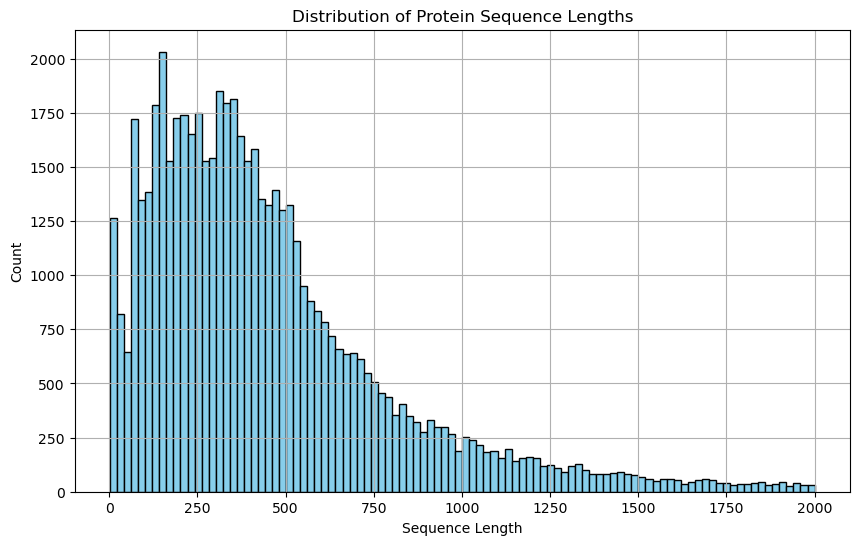

In [48]:
import matplotlib.pyplot as plt

test = training_data.copy()
test["Length"] = test["Sequence"].str.len()

long_sequences = test[test["Length"] > 10000]

print(long_sequences[["Entry", "Length"]])

# Plot der Längenverteilung
plt.figure(figsize=(10, 6))
plt.hist(test["Length"], bins=100, color="skyblue", edgecolor="black")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Protein Sequence Lengths")
plt.grid(True)
plt.show()


In [53]:
import subprocess

NUM_CHUNKS = 20
total      = len(training_data)
chunk_size = (total + NUM_CHUNKS - 1) // NUM_CHUNKS   # ceiling division

for part in range(NUM_CHUNKS):
    start = part * chunk_size
    end   = min(start + chunk_size, total)
    if start >= total:            # nothing left
        break

    chunk = training_data.iloc[start:end]
    fasta_path = f"../data/interm/training_data_part_{part+1}.fasta"
    write_fasta(chunk, fasta_path)
    print(f"✓ part {part+1:2d}: {len(chunk):>5} seq → {fasta_path} → {embed_path}")

    embed_path = f"../data/interm/training_embeds_{part+1}.h5"
    subprocess.run(
        [
            "python", "../generate_embeds.py",
            "-i", fasta_path,
            "-o", embed_path,
            "--per-protein",
            "--max-batch", "1",
            "--max-residues", "1000",
            "--max-seq-len", "500",
        ],
        check=True,
    )


Using device: mps


[2025-05-30 14:22:32] INFO: Using device: mps
[2025-05-30 14:22:32] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 14:22:33] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 14:22:34] INFO: Read 2841 sequences; avg len 105.98; >500: 64
Embedding sequences: 100%|██████████| 2841/2841 [04:06<00:00, 11.52seq/s]
[2025-05-30 14:26:41] INFO: Embeddings saved to ../data/interm/training_embeds_1.h5. Processed 2841 sequences in 246.68s (avg 0.0868s/seq).


✓ part  1:  2841 seq → ../data/interm/training_data_part_1.fasta → ../data/interm/training_embeds_1.h5
Using device: mps


[2025-05-30 14:26:44] INFO: Using device: mps
[2025-05-30 14:26:44] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 14:26:46] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 14:26:46] INFO: Read 2841 sequences; avg len 446.63; >500: 936
Embedding sequences: 100%|██████████| 2841/2841 [21:05<00:00,  2.24seq/s]
[2025-05-30 14:47:52] INFO: Embeddings saved to ../data/interm/training_embeds_2.h5. Processed 2841 sequences in 1266.01s (avg 0.4456s/seq).


✓ part  2:  2841 seq → ../data/interm/training_data_part_2.fasta → ../data/interm/training_embeds_2.h5
Using device: mps


[2025-05-30 14:47:58] INFO: Using device: mps
[2025-05-30 14:47:58] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 14:47:59] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 14:48:00] INFO: Read 2841 sequences; avg len 470.41; >500: 1001
Embedding sequences: 100%|██████████| 2841/2841 [21:42<00:00,  2.18seq/s]
[2025-05-30 15:09:43] INFO: Embeddings saved to ../data/interm/training_embeds_3.h5. Processed 2841 sequences in 1302.79s (avg 0.4586s/seq).


✓ part  3:  2841 seq → ../data/interm/training_data_part_3.fasta → ../data/interm/training_embeds_3.h5
Using device: mps


[2025-05-30 15:09:48] INFO: Using device: mps
[2025-05-30 15:09:48] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 15:09:50] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 15:09:50] INFO: Read 2841 sequences; avg len 463.91; >500: 998
Embedding sequences: 100%|██████████| 2841/2841 [21:15<00:00,  2.23seq/s]
[2025-05-30 15:31:06] INFO: Embeddings saved to ../data/interm/training_embeds_4.h5. Processed 2841 sequences in 1275.28s (avg 0.4489s/seq).


✓ part  4:  2841 seq → ../data/interm/training_data_part_4.fasta → ../data/interm/training_embeds_4.h5
Using device: mps


[2025-05-30 15:31:11] INFO: Using device: mps
[2025-05-30 15:31:11] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 15:31:12] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 15:31:13] INFO: Read 2841 sequences; avg len 463.60; >500: 995
Embedding sequences: 100%|██████████| 2841/2841 [22:13<00:00,  2.13seq/s]
[2025-05-30 15:53:26] INFO: Embeddings saved to ../data/interm/training_embeds_5.h5. Processed 2841 sequences in 1333.46s (avg 0.4694s/seq).


✓ part  5:  2841 seq → ../data/interm/training_data_part_5.fasta → ../data/interm/training_embeds_5.h5
Using device: mps


[2025-05-30 15:53:32] INFO: Using device: mps
[2025-05-30 15:53:32] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 15:53:34] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 15:53:34] INFO: Read 2841 sequences; avg len 462.89; >500: 929
Embedding sequences: 100%|██████████| 2841/2841 [23:12<00:00,  2.04seq/s]
[2025-05-30 16:16:47] INFO: Embeddings saved to ../data/interm/training_embeds_6.h5. Processed 2841 sequences in 1392.45s (avg 0.4901s/seq).


✓ part  6:  2841 seq → ../data/interm/training_data_part_6.fasta → ../data/interm/training_embeds_6.h5
Using device: mps


[2025-05-30 16:16:52] INFO: Using device: mps
[2025-05-30 16:16:52] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 16:16:54] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 16:16:54] INFO: Read 2841 sequences; avg len 473.08; >500: 996
Embedding sequences: 100%|██████████| 2841/2841 [21:54<00:00,  2.16seq/s]
[2025-05-30 16:38:49] INFO: Embeddings saved to ../data/interm/training_embeds_7.h5. Processed 2841 sequences in 1314.46s (avg 0.4627s/seq).


✓ part  7:  2841 seq → ../data/interm/training_data_part_7.fasta → ../data/interm/training_embeds_7.h5
Using device: mps


[2025-05-30 16:38:55] INFO: Using device: mps
[2025-05-30 16:38:55] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 16:38:56] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 16:38:57] INFO: Read 2841 sequences; avg len 474.93; >500: 1007
Embedding sequences: 100%|██████████| 2841/2841 [22:10<00:00,  2.14seq/s]
[2025-05-30 17:01:07] INFO: Embeddings saved to ../data/interm/training_embeds_8.h5. Processed 2841 sequences in 1330.33s (avg 0.4683s/seq).


✓ part  8:  2841 seq → ../data/interm/training_data_part_8.fasta → ../data/interm/training_embeds_8.h5
Using device: mps


[2025-05-30 17:01:13] INFO: Using device: mps
[2025-05-30 17:01:13] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 17:01:15] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 17:01:15] INFO: Read 2841 sequences; avg len 456.07; >500: 954
Embedding sequences: 100%|██████████| 2841/2841 [20:59<00:00,  2.26seq/s]
[2025-05-30 17:22:15] INFO: Embeddings saved to ../data/interm/training_embeds_9.h5. Processed 2841 sequences in 1259.87s (avg 0.4435s/seq).


✓ part  9:  2841 seq → ../data/interm/training_data_part_9.fasta → ../data/interm/training_embeds_9.h5
Using device: mps


[2025-05-30 17:22:21] INFO: Using device: mps
[2025-05-30 17:22:21] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 17:22:22] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 17:22:23] INFO: Read 2841 sequences; avg len 468.55; >500: 987
Embedding sequences: 100%|██████████| 2841/2841 [21:22<00:00,  2.22seq/s]
[2025-05-30 17:43:45] INFO: Embeddings saved to ../data/interm/training_embeds_10.h5. Processed 2841 sequences in 1282.55s (avg 0.4514s/seq).


✓ part 10:  2841 seq → ../data/interm/training_data_part_10.fasta → ../data/interm/training_embeds_10.h5
Using device: mps


[2025-05-30 17:43:51] INFO: Using device: mps
[2025-05-30 17:43:51] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 17:43:53] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 17:43:54] INFO: Read 2841 sequences; avg len 480.22; >500: 1027
Embedding sequences: 100%|██████████| 2841/2841 [22:05<00:00,  2.14seq/s]
[2025-05-30 18:05:59] INFO: Embeddings saved to ../data/interm/training_embeds_11.h5. Processed 2841 sequences in 1325.48s (avg 0.4666s/seq).


✓ part 11:  2841 seq → ../data/interm/training_data_part_11.fasta → ../data/interm/training_embeds_11.h5
Using device: mps


[2025-05-30 18:06:05] INFO: Using device: mps
[2025-05-30 18:06:05] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 18:06:07] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 18:06:08] INFO: Read 2841 sequences; avg len 467.17; >500: 993
Embedding sequences: 100%|██████████| 2841/2841 [20:58<00:00,  2.26seq/s]
[2025-05-30 18:27:06] INFO: Embeddings saved to ../data/interm/training_embeds_12.h5. Processed 2841 sequences in 1258.35s (avg 0.4429s/seq).


✓ part 12:  2841 seq → ../data/interm/training_data_part_12.fasta → ../data/interm/training_embeds_12.h5
Using device: mps


[2025-05-30 18:27:12] INFO: Using device: mps
[2025-05-30 18:27:12] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 18:27:13] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 18:27:14] INFO: Read 2841 sequences; avg len 455.47; >500: 957
Embedding sequences: 100%|██████████| 2841/2841 [20:39<00:00,  2.29seq/s]
[2025-05-30 18:47:54] INFO: Embeddings saved to ../data/interm/training_embeds_13.h5. Processed 2841 sequences in 1240.00s (avg 0.4365s/seq).


✓ part 13:  2841 seq → ../data/interm/training_data_part_13.fasta → ../data/interm/training_embeds_13.h5
Using device: mps


[2025-05-30 18:47:59] INFO: Using device: mps
[2025-05-30 18:47:59] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 18:48:01] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 18:48:02] INFO: Read 2841 sequences; avg len 466.28; >500: 997
Embedding sequences: 100%|██████████| 2841/2841 [21:52<00:00,  2.16seq/s]
[2025-05-30 19:09:54] INFO: Embeddings saved to ../data/interm/training_embeds_14.h5. Processed 2841 sequences in 1312.40s (avg 0.4620s/seq).


✓ part 14:  2841 seq → ../data/interm/training_data_part_14.fasta → ../data/interm/training_embeds_14.h5
Using device: mps


[2025-05-30 19:10:00] INFO: Using device: mps
[2025-05-30 19:10:00] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 19:10:02] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 19:10:02] INFO: Read 2841 sequences; avg len 466.00; >500: 957
Embedding sequences: 100%|██████████| 2841/2841 [20:51<00:00,  2.27seq/s]
[2025-05-30 19:30:53] INFO: Embeddings saved to ../data/interm/training_embeds_15.h5. Processed 2841 sequences in 1251.23s (avg 0.4404s/seq).


✓ part 15:  2841 seq → ../data/interm/training_data_part_15.fasta → ../data/interm/training_embeds_15.h5
Using device: mps


[2025-05-30 19:30:59] INFO: Using device: mps
[2025-05-30 19:30:59] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 19:31:01] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 19:31:02] INFO: Read 2841 sequences; avg len 467.96; >500: 1017
Embedding sequences: 100%|██████████| 2841/2841 [21:12<00:00,  2.23seq/s]
[2025-05-30 19:52:14] INFO: Embeddings saved to ../data/interm/training_embeds_16.h5. Processed 2841 sequences in 1272.33s (avg 0.4478s/seq).


✓ part 16:  2841 seq → ../data/interm/training_data_part_16.fasta → ../data/interm/training_embeds_16.h5
Using device: mps


[2025-05-30 19:52:20] INFO: Using device: mps
[2025-05-30 19:52:20] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 19:52:21] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 19:52:22] INFO: Read 2841 sequences; avg len 484.22; >500: 1055
Embedding sequences: 100%|██████████| 2841/2841 [22:22<00:00,  2.12seq/s]
[2025-05-30 20:14:45] INFO: Embeddings saved to ../data/interm/training_embeds_17.h5. Processed 2841 sequences in 1343.09s (avg 0.4728s/seq).


✓ part 17:  2841 seq → ../data/interm/training_data_part_17.fasta → ../data/interm/training_embeds_17.h5
Using device: mps


[2025-05-30 20:14:51] INFO: Using device: mps
[2025-05-30 20:14:51] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 20:14:52] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 20:14:53] INFO: Read 2841 sequences; avg len 472.90; >500: 1015
Embedding sequences: 100%|██████████| 2841/2841 [21:46<00:00,  2.18seq/s]
[2025-05-30 20:36:39] INFO: Embeddings saved to ../data/interm/training_embeds_18.h5. Processed 2841 sequences in 1306.20s (avg 0.4598s/seq).


✓ part 18:  2841 seq → ../data/interm/training_data_part_18.fasta → ../data/interm/training_embeds_18.h5
Using device: mps


[2025-05-30 20:36:45] INFO: Using device: mps
[2025-05-30 20:36:45] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 20:36:46] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 20:36:47] INFO: Read 2841 sequences; avg len 464.47; >500: 952
Embedding sequences: 100%|██████████| 2841/2841 [20:59<00:00,  2.26seq/s]
[2025-05-30 20:57:46] INFO: Embeddings saved to ../data/interm/training_embeds_19.h5. Processed 2841 sequences in 1259.66s (avg 0.4434s/seq).


✓ part 19:  2841 seq → ../data/interm/training_data_part_19.fasta → ../data/interm/training_embeds_19.h5
Using device: mps


[2025-05-30 20:57:52] INFO: Using device: mps
[2025-05-30 20:57:52] INFO: Loading T5EncoderModel Rostlab/prot_t5_xl_half_uniref50-enc
[2025-05-30 20:57:53] INFO: Skipping torch.compile(): not running on CUDA device.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
[2025-05-30 20:57:54] INFO: Read 2824 sequences; avg len 478.50; >500: 1012
Embedding sequences: 100%|██████████| 2824/2824 [22:07<00:00,  2.13seq/s]
[2025-05-30 21:20:02] INFO: Embeddings saved to ../data/interm/training_embeds_20.h5. Processed 2824 sequences in 1328.12s (avg 0.4703s/seq).


✓ part 20:  2824 seq → ../data/interm/training_data_part_20.fasta → ../data/interm/training_embeds_20.h5


## generate embeddings